# Aim

To tag which customers to market. Tagging done basis 'Response Model' + 'Profit Model' 

In [1]:
'''Definning path of the project'''
path = "D:/customer_quality_prediction/"

## Import Libraries 

In [2]:
#importing standard packages
import os
import pandas as pd
import pickle
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir(path)

#importing Functions created for Modeling purpose
exec(open("modeling_functions.py").read())

import warnings
warnings.filterwarnings("ignore")

## Loading Data

In [3]:
data = pd.read_csv(path + 'testingCandidate_csv.csv')

data.head()

,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,id
0,NaN,admin.,married,NaN,no,no,yes,cellular,sep,wed,...,1,failure,-1.1,94.199,-37.5,0.886,4963.6,999.0,2,1
1,35.0,services,married,high.school,no,no,no,cellular,sep,tue,...,1,success,-3.4,92.379,-29.8,0.788,5017.5,0.1,2,2
2,50.0,blue-collar,married,professional.course,unknown,yes,no,cellular,may,thu,...,1,failure,-1.8,92.893,-46.2,1.327,5099.1,999.0,2,3
3,30.0,admin.,single,university.degree,no,no,no,cellular,aug,wed,...,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,999.0,0,4
4,39.0,services,divorced,high.school,no,yes,no,cellular,nov,tue,...,0,nonexistent,-0.1,93.200,-42.0,4.153,5195.8,999.0,0,5


## Tagging Cases

In the First step: 'Response Model' is used. customers will be tagged whether they will respond to the insurance offer or not. If the customer is tagged as 'will respond' then they will be sent to second step: 'Profit Model', to know how much prodit will be generated by them.

#### 1. Response Model

In [4]:
#Numeric features in model
numeric_features = ['fl_first_time_contact', 'nr.employed']

#nominal features in model
nominal_features = ['contact', 'month', 'poutcome', 'profession']

#Feature Creation
data['fl_first_time_contact'] = np.where(data['previous'] > 0, 0, 1)

#keeping only relevant features
data = data[['id'] + numeric_features + nominal_features]


'''Binning Numeric Variables'''

#loading bucket threshold
with open(path + 'pickle_response_model/thold_dict.p', 'rb') as f:
    dict_thold = pickle.load(f)

#Binning the variables using pickled threshold
data_binned = data.copy()
for feature in numeric_features:
    if feature != 'fl_first_time_contact':  #this feature was not binned
        thold = dict_thold[feature][1:-1]
        #print(feature + ": "+ str(thold))
        new_values = []
        for value in data[feature]:
            flag = 0
            for i in range(len(thold)):
                if(value < thold[i]):
                    new_values.append(i)
                    flag = 1
                    break
            if(flag == 0):
                new_values.append(len(thold))
        data_binned[feature] = new_values


'''
Below snippet is useful when a feature in a test set has an additional category which was never faced in train set, 
hence removing it after one_hot_encoding. To make sure whatever category where there in train are present in test,
we append test_ohe to structure of train_ohe dataframe and impute missing value with zero.
'''

#getting final one hot encoded features from model
with open(path + "pickle_response_model/final_features.p", "rb") as f:
    final_model_features = pickle.load(f)
    
final_model_features.append('id')

#creating an empty dataframe which will have one hot encoded data, of similar structure from training time.
data_ohe = pd.DataFrame(columns = final_model_features)

#one hot encoding nominal features of testing data.
data_ohe_temp = pd.get_dummies(data_binned, columns = nominal_features)

#identifying and removing columns which are created for unseen category during training time. 
unnecessary_col = []
for feature in data_ohe_temp.columns:
    if feature not in final_model_features:
        unnecessary_col.append(feature)
        
data_ohe_temp.drop(columns = unnecessary_col, inplace = True)

#appending test one hot encoded data to above empty dataframe having training data structure.
data_ohe = data_ohe.append(data_ohe_temp)

#if some category was present in train data but not in test, then Null would appear after above step
#hence replacing null with zero
data_ohe.fillna(value = 0, inplace = True)


'''getting Model output'''

with open(path + "pickle_response_model/log_reg_final.p", "rb") as f:
    log_reg_final = pickle.load(f)

#getting prediction
prediction = data_ohe[['id']]    
prediction['probability_class_1'] = log_reg_final.predict_proba(data_ohe.drop(columns = ['id']))[:,1]
prediction['pred_class'] = np.where(prediction['probability_class_1'] > 0.22, 1, 0)  #1 means will respond.

prediction_test = pd.read_pickle(path + "pickle_response_model/prediction_test.p")

'''PSI'''
#Comparing current Probability distribution with Testing Probability distribution
psi = calculate_psi_continuous(expected = prediction_test['probability_class_1'], actual = prediction['probability_class_1'])

print("PSI:" + str(round(psi,5)))

print("Response Rate for {} customers in current Batch:\n++++++++++++++++++++++++++++".format(len(prediction)))
print(prediction['pred_class'].value_counts() * 100/ len(prediction))

PSI:0.001
Response Rate for 32950 customers in current Batch:
++++++++++++++++++++++++++++
0    87.817906
1    12.182094
Name: pred_class, dtype: float64


As PSI is 0.001 (i.e. < 0.1), we can be assured that there is no concept drift or data drift and this model is holding true for this batch.

Also,12% of 32,950 = 4,013 customers, may respond to the offer. 

#### 2. Profit Model

In this step, only generating profit for the customer for whom we think will repond as per the 'Response Model'. 

In [5]:
#customers who would respond
reponding_id = prediction[(prediction['pred_class'] == 1)][['id']] 

#loading data:
data = pd.read_csv(path + 'testingCandidate_csv.csv')

#pickling only customers who would respond from main data:
data = data.merge(reponding_id, on = 'id').reset_index(drop = True)

#nominal features in model
nominal_features = ['default', 'loan', 'marital', 'profession', 'schooling']

'''Null Imputation'''
data['schooling'] = np.where(data['schooling'].isna(), 'unknown', data['schooling'])

#keeping only relevant features
data = data[['id'] + nominal_features]

'''
Below snippet is useful when a feature in a test set has an additional category which was never faced in train set, 
hence removing it after one_hot_encoding. To make sure whatever category where there in train are present in test,
we append test_ohe to structure of train_ohe dataframe and impute missing value with zero.
'''

#getting final one hot encoded features from model
with open(path + "pickle_profit/final_features.p", "rb") as f:
    final_model_features = pickle.load(f)
    
final_model_features.append('id') 

#creating an empty dataframe which will have one hot encoded data, of similar structure from training time.
data_ohe = pd.DataFrame(columns = final_model_features)

#one hot encoding nominal features of testing data.
data_ohe_temp = pd.get_dummies(data, columns = nominal_features)

#identifying and removing columns which are created for unseen category during training time. 
unnecessary_col = []
for feature in data_ohe_temp.columns:
    if feature not in final_model_features:
        unnecessary_col.append(feature)
        
data_ohe_temp.drop(columns = unnecessary_col, inplace = True)

#appending test one hot encoded data to above empty dataframe having training data structure.
data_ohe = data_ohe.append(data_ohe_temp)

#if some category was present in train data but not in test, then Null would appear after above step
#hence replacing null with zero
data_ohe.fillna(value = 0, inplace = True)

'''getting Model output and performance for Test set'''

with open(path + "pickle_profit/lasso_final.p", "rb") as f:
    lasso_final = pickle.load(f)

#getting prediction
X_test = data_ohe.drop(columns = ['id'])

prediction = data_ohe[['id']]    
prediction['pred_profit'] = lasso_final.predict(X_test)


#getting prediction dataframe for PSI comparison from test time:
prediction_test = pd.read_pickle(path + "pickle_profit/prediction_train.p")

'''PSI'''
#Comparing current Probability distribution with Testing Probability distribution
psi = calculate_psi_continuous(expected = prediction_test['pred_profit'], actual = prediction['pred_profit'])

print("PSI:" + str(round(psi,5)))

PSI:0.12586


the above PSI is 0.125 (i.e. > 0.1, meaning distribution of the model ouptut has changed slightly), but to confirm let's check their actual overlap.

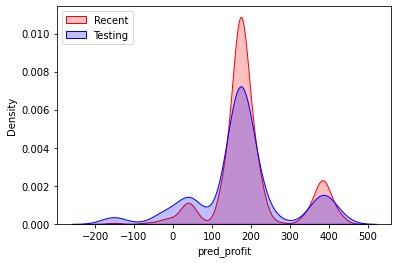

<Figure size 432x288 with 0 Axes>

In [6]:
'''plotting overlap of Testing time Predicted Profit with current batch predicted profit'''

p1 = sns.kdeplot(prediction['pred_profit'], shade=True, color="r", label = 'Recent')
p2 = sns.kdeplot(prediction_test['pred_profit'], shade=True, color="b", label = 'Testing')
plt.legend(loc='upper left')
plt.show()
plt.clf()

The above overlap seems good enough. There seems no concept drift by looking at distributions, could be because of higher cases in the Recent Batch.

#### 3. profit_customers_who_would_respond

To optimize the profit during the campain, we can shortlist customers whose Model predicted atleast 106 profit. Because, we saw that ~96% of customers whose profit is predicted falls in the range of 95% Prediction interval. i.e. Even if a person's profit is predicted as 106 (actual profit is 1) we will be on safer side.

In [11]:
data = pd.read_csv(path + "testingCandidate_csv.csv")

In [12]:
#customers with predicted profit >= 106
profit_customers_who_will_respond = prediction[prediction['pred_profit'] > 106][['id']]
profit_customers_who_will_respond['should_market'] = 1

#merging with given data
data = data.merge(profit_customers_who_will_respond, 
                 on = 'id',
                 how = 'left')

data['should_market'] = np.where(data['should_market'].isna(), 0, 1)

print("outof {} customers in current Batch:\n++++++++++++++++++++++++++++".format(len(data)))
print(data['should_market'].value_counts() * 100 / len(data))

outof 32950 customers in current Batch:
++++++++++++++++++++++++++++
0    88.786039
1    11.213961
Name: should_market, dtype: float64


11% customers should be marketed

In [14]:
'''the output file'''

'''Output columns: should_market'''

data.to_csv(path + "testingCandidate_with_output.csv", index = False)